# Demonstration of Authentrics.ai Static & Dynamic Analysis
**Note: This demo uses publicly available aircraft types for classification purposes.**
**No sensitive or classified military information is included.**

## Setup

### Install dependencies and utility functions: This cell should be run once.

In [1]:
%%capture

%pip install matplotlib numpy pandas requests tqdm ipywidgets
%pip install --ignore-installed 'git+https://github.com/Authentrics-ai/authentrics-client.git@fallback-release'

from pathlib import Path

import os
import authentrics_client as authrx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from datetime import datetime
import time
from tqdm.notebook import tqdm
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from threading import Thread
import contextlib

# Utility functions for loading indicators
@contextlib.contextmanager
def loading_spinner(message="Processing..."):
    """Context manager for showing a loading spinner"""
    spinner_widget = widgets.HTML(value=f"""
    <div style="display: flex; align-items: center; gap: 10px;">
        <div style="width: 20px; height: 20px; border: 2px solid #f3f3f3; border-top: 2px solid #3498db; border-radius: 50%; animation: spin 1s linear infinite;"></div>
        <span style="font-size: 14px; color: #555;">{message}</span>
    </div>
    <style>
    @keyframes spin {{
        0% {{ transform: rotate(0deg); }}
        100% {{ transform: rotate(360deg); }}
    }}
    </style>
    """)
    display(spinner_widget)
    try:
        yield
    finally:
        spinner_widget.close()

def show_progress_bar(total, description="Progress"):
    """Create and return a progress bar"""
    return tqdm(total=total, desc=description, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')

def wait_for_analytics(project_id, min_wait_time=30, max_wait_time=300, check_interval=10):
    """
    Wait for ALL analytics to be complete before continuing.
    This prevents NaN values from appearing in the summary table.
    """
    import time

    print("🔄 Waiting for analytics to process...")
    countdown_widget = widgets.HTML()
    display(countdown_widget)

    # Minimum wait with countdown
    for remaining in range(min_wait_time, 0, -1):
        countdown_widget.value = f"""
        <div style="display: flex; align-items: center; gap: 10px; margin: 10px 0;">
            <div style="width: 20px; height: 20px; border: 2px solid #f3f3f3; border-top: 2px solid #3498db; border-radius: 50%; animation: spin 1s linear infinite;"></div>
            <span style="font-size: 14px; color: #555;">Minimum wait period: {remaining} seconds remaining...</span>
        </div>
        <style>
        @keyframes spin {{
            0% {{ transform: rotate(0deg); }}
            100% {{ transform: rotate(360deg); }}
        }}
        </style>
        """
        time.sleep(1)

    # Poll until ALL analytics are complete
    start_polling = time.time()
    attempt = 1

    while (time.time() - start_polling) < (max_wait_time - min_wait_time):
        try:
            project = client.project.get_project_by_id(project_id)
            files = project["file_list"][1:]  # Skip base model

            # Check that ALL files have both weight and bias contributions
            files_missing_analytics = []
            for f in files:
                if (f.get("total_weight_contribution") is None or
                    f.get("total_bias_contribution") is None):
                    files_missing_analytics.append(f["file_name"])

            # Only continue if ALL analytics are complete
            if not files_missing_analytics:
                countdown_widget.value = """
                <div style="color: green; font-weight: bold; margin: 10px 0;">
                    ✅ All analytics are complete!
                </div>
                """
                return True

            # Show progress with specific missing files
            total_files = len(files)
            completed_files = total_files - len(files_missing_analytics)
            progress_pct = (completed_files / total_files * 100) if total_files > 0 else 0

            missing_display = ', '.join(files_missing_analytics[:3])
            if len(files_missing_analytics) > 3:
                missing_display += f" and {len(files_missing_analytics) - 3} more"

            countdown_widget.value = f"""
            <div style="display: flex; align-items: center; gap: 10px; margin: 10px 0;">
                <div style="width: 20px; height: 20px; border: 2px solid #f3f3f3; border-top: 2px solid #orange; border-radius: 50%; animation: spin 1s linear infinite;"></div>
                <span style="font-size: 14px; color: #555;">
                    Attempt {attempt}: {completed_files}/{total_files} files complete ({progress_pct:.1f}%)
                    <br/>⏳ Waiting for: {missing_display}
                </span>
            </div>
            <style>
            @keyframes spin {{
                0% {{ transform: rotate(0deg); }}
                100% {{ transform: rotate(360deg); }}
            }}
            </style>
            """
            attempt += 1
            time.sleep(check_interval)

        except Exception as e:
            print(f"⚠️ Error checking analytics status: {e}")
            time.sleep(check_interval)

    # Timeout reached - show final status
    try:
        project = client.project.get_project_by_id(project_id)
        files = project["file_list"][1:]
        files_missing_analytics = [f["file_name"] for f in files
                                 if (f.get("total_weight_contribution") is None or
                                     f.get("total_bias_contribution") is None)]

        if files_missing_analytics:
            countdown_widget.value = f"""
            <div style="color: red; font-weight: bold; margin: 10px 0;">
                ⚠️ Timeout: Analytics incomplete for {len(files_missing_analytics)} files.
                <br/>NaN values will appear for: {', '.join(files_missing_analytics[:5])}
                <br/>Consider increasing wait time or contacting support.
            </div>
            """
            return False
        else:
            countdown_widget.value = """
            <div style="color: green; font-weight: bold; margin: 10px 0;">
                ✅ All analytics completed just in time!
            </div>
            """
            return True
    except Exception as e:
        countdown_widget.value = f"""
        <div style="color: red; font-weight: bold; margin: 10px 0;">
            ❌ Error checking final status: {e}
        </div>
        """
        return False

### Contact Authentrics for the URL and user credentials info@authentrics.ai

In [2]:
DEMO_SERVER_URL = input("Enter your Authentrics URL: ")
PROJECT_NAME = "Military Aircraft Classification"

pd.options.display.precision = 5
pd.options.display.chop_threshold = None

classes = [
    "A10", "AH64", "B1", "B52",
    "C130", "C17", "C2", "EF2000",
    "F15", "F16", "F18", "F22",
    "F35", "F4", "J10", "J20",
    "JAS39", "Rafale", "US2", "V22",
]

### Establish a session with Authentrics
- Rerun this cell if your session expires

In [3]:
client = authrx.AuthentricsClient(DEMO_SERVER_URL)
client.auth.login()
print("✅ Session established successfully!")

✅ Session established successfully!


### Generate a project in Authentrics to track checkpoints, and perform asynchronous analytics
1. Creates a project for checkpoint management.
2. **Option A**: Point to existing checkpoint storage (no data movement required).
3. **Option B**: Upload checkpoints directly through our client (automated storage and versioning).

In [4]:
projects = client.project.get_projects()
if projects is not None:
    project = next((p for p in projects if p["name"].startswith(PROJECT_NAME)), None)
    if project:
        client.project.delete_project(project["id"])

PROJECT_NAME = PROJECT_NAME + " " + str(int(datetime.now().timestamp()))
project = client.project.create_project(
    PROJECT_NAME,
    "A classification CNN for some military aircraft",
    authrx.FileType.ONNX,
)
project_id = project["id"]

### Setup the checkpoints for demonstration

In [5]:
with loading_spinner("Please wait while we restore the checkpoint files..."):
    client.get('/transfer/MilAir')

HTML(value='\n    <div style="display: flex; align-items: center; gap: 10px;">\n        <div style="width: 20p…

### Point the authentrics file registry to the checkpoints using the api

In [6]:

print("Adding checkpoints to project...")
with show_progress_bar(7, "Adding checkpoints") as pbar:
    for i in range(7):
        client.checkpoint.add_external_checkpoint(
            project_id,
            f"demo-models/MilAir/checkpoint_{i+1}.onnx",
            authrx.FileType.ONNX,
            file_name=f"checkpoint_{i+1}.onnx",
            tag=f"v{i+1}",
        )
        pbar.update(1)
project = client.project.get_project_by_id(project_id)
print(f"Project created with id: {project_id}")
print(f"Project name: {project['name']}")
for file in project["file_list"]:
    print(f"File name: {file['file_name']}")

# Wait for analytics to be processed before proceeding
print("\n" + "="*60)
print("📊 ANALYTICS PROCESSING")
print("="*60)
print("Authentrics is now computing analytics in the background.")
print("This includes weight contributions and bias scores for each checkpoint.")

analytics_ready = wait_for_analytics(project_id, min_wait_time=15, max_wait_time=180)
if not analytics_ready:
    print("\n❌ Analytics are not complete.")
    print("Please wait a moment longer and then continue. Please contact support if the issue persists.")

Adding checkpoints to project...


Adding checkpoints:   0%|          | 0/7 [00:00<?]

Project created with id: 68a627783474e04f1f93ac6c
Project name: Military Aircraft Classification 1755719544
File name: checkpoint_1.onnx
File name: checkpoint_2.onnx
File name: checkpoint_3.onnx
File name: checkpoint_4.onnx
File name: checkpoint_5.onnx
File name: checkpoint_6.onnx
File name: checkpoint_7.onnx

📊 ANALYTICS PROCESSING
Authentrics is now computing analytics in the background.
This includes weight contributions and bias scores for each checkpoint.
🔄 Waiting for analytics to process...


HTML(value='')

Below we define helper functions for visualizing analytics and running inference


In [7]:
def softmax(x):
    """Compute softmax of a 1D array"""
    e = np.exp(x)
    return e / np.sum(e, axis=-1)

def display_sensitivity_results(result: dict, columns: list[str], classes: list[str]):
    """Display results in a table using Pandas"""
    series = {}
    for col in columns:
        arr = np.asarray(result[col]).flatten()
        series[col] = softmax(arr) * 100

    return pd.DataFrame(series, index=classes)

def plot_heatmap(results, layer_name):
    """Plot static analysis of several checkpoints using matplotlib"""
    arr = np.stack([
        result["absolute_bias_difference"][layer_name]
        for result in results
    ], axis=1)
    num_results = len(results)

    plt.matshow(arr)
    plt.colorbar(aspect=10)

    plt.xlabel("Checkpoint")
    plt.ylabel("Bias Shift")

    plt.xticks(range(num_results), np.arange(num_results) + 2)
    plt.yticks(list(range(len(classes))), sorted(classes))

    plt.show()

def plot_contributions(project_id):
    # Get files
    project = client.project.get_project_by_id(project_id)
    files = project['file_list']

    weights = [f['total_weight_contribution'] for f in files]
    bias = [f['total_bias_contribution'] for f in files]
    file_names = [f['file_name'] for f in files]

    # --- First plot: Weight Contributions ---
    fig1, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(range(len(weights)), weights, marker='o', linestyle='-', alpha=0.6)
    ax1.set_xticks(range(len(weights)))
    ax1.set_xticklabels(file_names, rotation=45, ha='right')
    ax1.set_xlabel('Checkpoints')
    ax1.set_ylabel('Total Weight Contribution')
    ax1.set_title('Weight Contributions by Training')
    fig1.tight_layout()

    # --- Second plot: Bias Contributions ---
    fig2, ax2 = plt.subplots(figsize=(10, 7))
    ax2.plot(range(len(bias)), bias, marker='o', linestyle='-', alpha=0.6)
    ax2.set_xticks(range(len(bias)))
    ax2.set_xticklabels(file_names, rotation=45, ha='right')
    ax2.set_xlabel('Checkpoints')
    ax2.set_ylabel('Total Bias Contribution')
    ax2.set_title('Bias Contributions by Training')
    fig2.tight_layout()

    plt.show()

## Analytics Results

Authentrics computes analytics in the background to track model changes across training iterations.

1. **Weight shift tracking**: The plot below demonstrates the average weight contribution changes as percentages, tracking how model weights evolve from one checkpoint to the next during training.

2. **Integration ready**: This raw analytics data can trigger alerts for unusual changes or integrate with your existing business intelligence tools.

3. **Data availability**: If you don't see the graph, analytics are still processing. Wait a few minutes and rerun the cell.



HTML(value='\n    <div style="display: flex; align-items: center; gap: 10px;">\n        <div style="width: 20p…

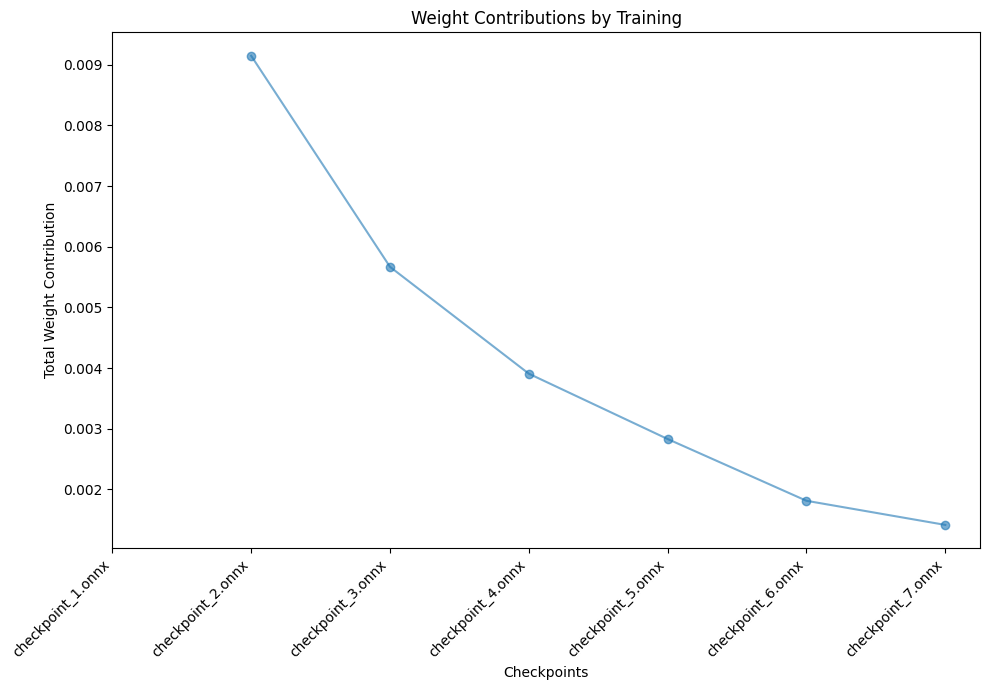

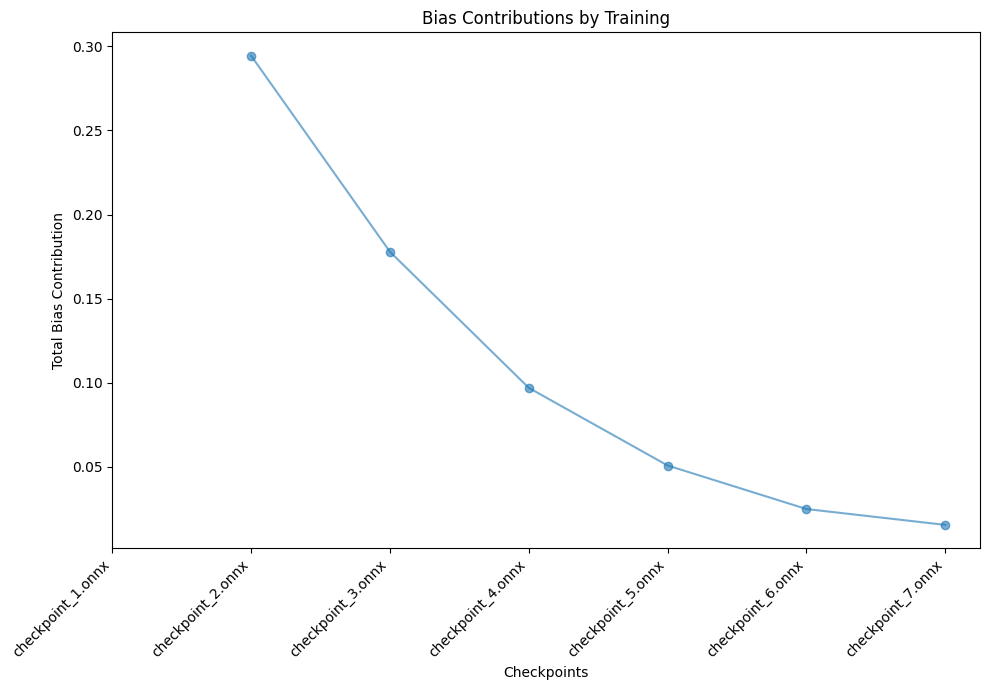

In [8]:
with loading_spinner("Generating weight contributions plot..."):
    plot_contributions(project_id)

### Static Analysis

Static analysis is fast, even for a large model. There is no inference performed; we only inspect the parameters within the checkpoint itself.

In [9]:
%%time
## Call Authentrics.ai software's static analysis
file_ids = [f["id"] for f in project["file_list"]]
with loading_spinner("Running static analysis..."):
    result = client.static.static_analysis(project_id, file_ids[1])

HTML(value='\n    <div style="display: flex; align-items: center; gap: 10px;">\n        <div style="width: 20p…

CPU times: user 59.9 ms, sys: 12 ms, total: 71.9 ms
Wall time: 2.33 s


This lists all the names of the bias parameters within the model.

In [10]:
list(result["absolute_bias_difference"].keys())

['squeeze_edit_model.features.0.1.bias',
 'squeeze_edit_model.features.1.0.block.0.1.bias',
 'squeeze_edit_model.features.1.0.block.1.fc1.bias',
 'squeeze_edit_model.features.1.0.block.1.fc2.bias',
 'squeeze_edit_model.features.1.0.block.2.1.bias',
 'squeeze_edit_model.features.1.1.block.0.1.bias',
 'squeeze_edit_model.features.1.1.block.1.fc1.bias',
 'squeeze_edit_model.features.1.1.block.1.fc2.bias',
 'squeeze_edit_model.features.1.1.block.2.1.bias',
 'squeeze_edit_model.features.2.0.block.0.1.bias',
 'squeeze_edit_model.features.2.0.block.1.1.bias',
 'squeeze_edit_model.features.2.0.block.2.fc1.bias',
 'squeeze_edit_model.features.2.0.block.2.fc2.bias',
 'squeeze_edit_model.features.2.0.block.3.1.bias',
 'squeeze_edit_model.features.2.1.block.0.1.bias',
 'squeeze_edit_model.features.2.1.block.1.1.bias',
 'squeeze_edit_model.features.2.1.block.2.fc1.bias',
 'squeeze_edit_model.features.2.1.block.2.fc2.bias',
 'squeeze_edit_model.features.2.1.block.3.1.bias',
 'squeeze_edit_model.feat

Performing static analysis on all the checkpoints can provide an overview of the model's transformation.

In [11]:
%%time
## Call Authentrics.ai software's static analysis for each checkpoint file
with loading_spinner("Running static analysis for each checkpoint file..."):
    results = [
        client.static.static_analysis(project_id, project["file_list"][i]["id"])
        for i in range(1, 7)
    ]
print("✅ Static analysis complete")

HTML(value='\n    <div style="display: flex; align-items: center; gap: 10px;">\n        <div style="width: 20p…

✅ Static analysis complete
CPU times: user 347 ms, sys: 77 ms, total: 424 ms
Wall time: 13.7 s


The heatmap below shows the shift in bias values that occured between the labeled checkpoint and the one before it. In checkpoint 4, we labeled all F-series fighter jets as F4. In checkpoint 5, we revert to correctly labeled data. All other values lie in a small range around 0, indicating business as usual.

HTML(value='\n    <div style="display: flex; align-items: center; gap: 10px;">\n        <div style="width: 20p…

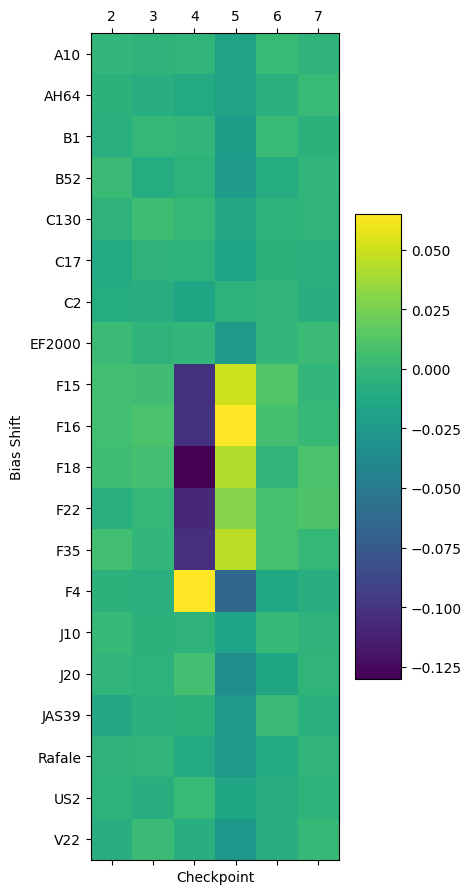

In [12]:
with loading_spinner("Generating heatmap..."):
    plot_heatmap(results, "squeeze_edit_model.classifier.4.bias")

#### Authentrics software enables rapid identification of critical training issues

Integration into your training workflow enables proactive issue detection, preventing problematic models from reaching production.

### Dynamic Analysis With Sensitivity

1. We run a stimulus of an f18 image through the model utilizing dymamic analysis on checkpoint 6 training data
2. We attenuate (lessen) the effects of that training content and evaluate impact

In [13]:
stimulus_name = "F18.jpg" # @param {"type":"string"}

In [14]:
os.makedirs("sample_images", exist_ok=True)
!wget -O sample_images/{stimulus_name} https://raw.githubusercontent.com/Authentrics-ai/demos/main/MilitaryAircraft/sample_images/{stimulus_name}
filepath = f"sample_images/{stimulus_name}"

--2025-08-20 19:53:04--  https://raw.githubusercontent.com/Authentrics-ai/demos/main/MilitaryAircraft/sample_images/F18.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3979 (3.9K) [image/jpeg]
Saving to: ‘sample_images/F18.jpg’

sample_images/F18.j 100%[===================>]   3.89K  --.-KB/s    in 0s      

2025-08-20 19:53:04 (69.5 MB/s) - ‘sample_images/F18.jpg’ saved [3979/3979]



#### Vary the effect of the data in checkpoint 6 by 2%

In [15]:
%%time
## Call Authentrics.ai software's sensitivity analysis
print("Running sensitivity analysis...")
amplitude = "0.02"
with loading_spinner("Running sensitivity analysis..."):
    result = client.dynamic.single_sensitivity_analysis(
        project_id,
        project["file_list"][5]["id"],
        stimulus_path=filepath,
        amplitude=amplitude,
    )
print(f"✅ Sensitivity analysis complete. Data attenuated by {amplitude}%.")

Running sensitivity analysis...


HTML(value='\n    <div style="display: flex; align-items: center; gap: 10px;">\n        <div style="width: 20p…

✅ Sensitivity analysis complete. Data attenuated by 0.02%.
CPU times: user 13.3 ms, sys: 2.04 ms, total: 15.4 ms
Wall time: 3.54 s


Below, we show that the image of the F18 is correctly identified with greater confidence when the influence of checkpoint 6's training is attenuated by 2%.

In [16]:
display_sensitivity_results(result, ["model_output", "attenuated_model_output"], classes)

,model_output,attenuated_model_output
A10,0.25101,0.19127
AH64,0.00183,0.00110
B1,0.00546,0.00358
B52,0.00132,0.00069
C130,0.02841,0.01603
C17,0.00507,0.00276
C2,0.00589,0.00357
EF2000,0.00176,0.00104
F15,0.04834,0.03183
F16,0.02403,0.01553


#### Vary the effect of the data in checkpoint 6 by 4%

In [17]:
%%time
## Call Authentrics.ai software's sensitivity analysis
print("Running sensitivity analysis...")
amplitude = "0.04"
with loading_spinner("Running sensitivity analysis..."):
    result = client.dynamic.single_sensitivity_analysis(
        project_id,
        project["file_list"][5]["id"],
        filepath,
        amplitude,
    )
print(f"✅ Sensitivity analysis complete. Data attenuated by {amplitude}%.")

Running sensitivity analysis...


HTML(value='\n    <div style="display: flex; align-items: center; gap: 10px;">\n        <div style="width: 20p…

✅ Sensitivity analysis complete. Data attenuated by 0.04%.
CPU times: user 6.47 ms, sys: 1.03 ms, total: 7.5 ms
Wall time: 4.39 s


Similarly, when amplified by 4%, the model increases its confidence. However, this amplified model must be checked against other stimuli to ensure that it does not skew the rest of the results (batch analysis to come).

In [18]:
display_sensitivity_results(result, ["model_output", "attenuated_model_output"], classes)

,model_output,attenuated_model_output
A10,0.26213,0.15482
AH64,0.00197,0.00077
B1,0.00604,0.00272
B52,0.00105,0.00030
C130,0.03898,0.01298
C17,0.00476,0.00145
C2,0.00411,0.00152
EF2000,0.00132,0.00047
F15,0.04442,0.02043
F16,0.02574,0.01124
